# LP2 Classifiacation Problem

### 1. Business Understanding
#### 1.1 Description 

In today's rapidly evolving telecommunications industry, service providers face intense competition, making the retention of existing customers a critical challenge. It is well-known that the cost of acquiring new customers outweighs that of retaining existing ones. To address this challenge, our project aims to develop a churn prediction model to forecast customer attrition and facilitate targeted retention strategies. 

#### 1.2 Objective  
The primary objective of this project is to create an efficient churn prediction model that can identify customers at risk of churning. By proactively identifying potential churners, the telecom company can take timely and personalized actions to retain valuable customers and prevent revenue loss.  

#### 1.3 Approach 
Our approach involves implementing machine learning techniques for churn prediction. We will explore and compare the performance of two popular algorithms: Logistic Regression, Decision Trees, Random Forest, and Support Vector Machines (SVM). 

  
### 2. Data understanding
There are 3 datasets used in this project. They all contain information about customers in a Telecom company. The following describes the columns present in the data.

* **Gender** -- Whether the customer is a male or a female

* **Partner** -- Whether the customer has a partner or not (Yes, No)

* **SeniorCitizen** -- Whether a customer is a senior citizen or not

* **Dependents** -- Whether the customer has dependents or not (Yes, No)

* **Tenure** -- Number of months the customer has stayed with the company

* **Phone Service** -- Whether the customer has a phone service or not (Yes, No)

* **InternetService** -- Customer's internet service provider (DSL, Fiber Optic, No)

* **MultipleLines** -- Whether the customer has multiple lines or not

* **OnlineSecurity** -- Whether the customer has online security or not (Yes, No, No Internet)

* **OnlineBackup** -- Whether the customer has online backup or not (Yes, No, No Internet)

* **DeviceProtection** -- Whether the customer has device protection or not (Yes, No, No internet service)

* **TechSupport** -- Whether the customer has tech support or not (Yes, No, No internet)

* **StreamingTV** -- Whether the customer has streaming TV or not (Yes, No, No internet service)

* **StreamingMovies** -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

* **Contract** -- The contract term of the customer (Month-to-Month, One year, Two year)

* **PaperlessBilling** -- Whether the customer has paperless billing or not (Yes, No)

* **Payment Method** -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

* **MonthlyCharges** -- The amount charged to the customer monthly

* **TotalCharges** -- The total amount charged to the customer

* **Churn** -- Whether the customer churned or not (Yes or No)


<br>

#### **Installing and importing libraries**


In [1]:
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install scikit-learn==1.2.2

In [3]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime

#Machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable
# Warning libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

## **Loading data**

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [6]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
#Checking if columns are same before concatination
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [9]:
# Concatenate the DataFrames to get one data set for the work
data=pd.concat([df1,df2])
data.to_csv('data/complete.csv',index=False)
# data=pd.read_csv("data/complete.csv")
data.sample(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
107,9750-BOOHV,Female,0,False,False,32,False,None,DSL,True,...,False,False,False,False,One year,False,Mailed check,30.150000,927.65,False
2336,3211-ILJTT,Male,0,True,False,17,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Bank transfer (automatic),70.400002,1214.05,True
1145,5010-IPEAQ,Female,0,Yes,Yes,67,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),54.200000,3623.95,No
1080,0301-KOBTQ,Male,0,False,False,32,True,False,No,None,...,None,None,None,None,Two year,True,Bank transfer (automatic),20.049999,614.45,False
1879,3494-JCHRQ,Male,0,False,False,1,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.050003,70.05,True
1496,2474-BRUCM,Male,1,Yes,No,40,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,101.850000,4086.3,Yes
1600,4592-IWTJI,Female,0,Yes,Yes,3,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Credit card (automatic),29.700000,91.7,Yes
2229,3496-LFSZU,Male,0,True,False,4,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,False,Electronic check,70.500000,294.2,False
2920,9453-PATOS,Female,0,True,False,72,True,False,DSL,True,...,True,True,True,True,Two year,False,Mailed check,85.099998,6155.4,False
460,4719-UMSIY,Male,0,False,True,6,True,False,No,None,...,None,None,None,None,Month-to-month,False,Mailed check,19.650000,100.9,False


## **Previewing the test datset**

In [10]:
#Preview the data
print(data.shape,"\n")
print(data.info())

(5043, 21) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-nu

## **From the summary above:**
* ### All columns are string except for ```SeniorCitizen``` ,```tenure ``` and  ```MonthlyCharges```
* ### There are missing values in several columns.

In [11]:
#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [0 1]

Unique values of Partner are [True False 'No' 'Yes']

Unique values of Dependents are [False True 'No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are [False True 'Yes' 'No']

Unique values of MultipleLines are [None False True 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are [False True None 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are [True False None 'No' 'Yes' 'No internet service']

Unique values of DeviceProtection are [False Tr

## **Issues arising :**
* ### Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
* ### For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
* ### The ```TotalCharges``` column should be converted to float datatype.

## **3. Data preparation**

### **3.1 Data cleaning**
### **Dealing with duplicates**

In [12]:
data.duplicated().value_counts()

False    5043
dtype: int64

### **The data contains no duplicates.**

### **Data uniformity**

* #### The ```TotalCharges``` and ```MonthlyCharges``` columns have different decimal places so we are going to standardize the columns to 2 dp. 

* #### But first of all, the ```TotalCharges``` column needs to be converted to a numeric data type as it is in string format.




In [13]:
#Converting to numric data type
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")
data["TotalCharges"].dtype

dtype('float64')

In [14]:
#Formatting to 2 decimal places
data["MonthlyCharges"]= data["MonthlyCharges"].round(2)
data["TotalCharges"] = data["TotalCharges"].round(2)
data[["MonthlyCharges","TotalCharges"]].sample(4)


,MonthlyCharges,TotalCharges
831,25.05,963.95
764,93.75,5625.55
808,108.40,7719.50
1466,49.20,571.15


### **Cleaning the categorical columns**

In [15]:
# Function to convert 'Yes'/'No' values to booleans


def convert_to_boolean(df, column):

    def convert_value(value): 

        if value == "Yes":
            return True

        elif value == "No":
            return False

        else:
            return value

    df[column] = df[column].apply(convert_value)

    return df



In [16]:
# Invoke function to convet for all columns in data


for col in data.columns:
    data = convert_to_boolean(data, col)

In [17]:
# Validate

#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [0 1]

Unique values of Partner are [ True False]

Unique values of Dependents are [False  True]

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are [False  True]

Unique values of MultipleLines are [None False True 'No phone service']

Unique values of InternetService are ['DSL' 'Fiber optic' False]

Unique values of OnlineSecurity are [False True None 'No internet service']

Unique values of OnlineBackup are [True False None 'No internet service']

Unique values of DeviceProtection are [False True None 'No internet service']

Unique values of TechSupport a

### **Handling missing values**

In [18]:
#Checking missing values
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [19]:
#Getting stastistical summary for `TotalCharges` to inform imputation
data["TotalCharges"].describe()

count    5035.000000
mean     2302.062860
std      2269.483575
min        18.800000
25%       417.675000
50%      1401.150000
75%      3862.000000
max      8670.100000
Name: TotalCharges, dtype: float64


## **Decison mades:**

* #### Given that ```OnlineSecurity```, ```OnlineBackup``` ,```DeviceProtection```  ,```TechSupport```, ```StreamingTV```,```StreamingMovies``` and ```Mutliple lines``` are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with False. This is because in the real world , if someone doesn't fill an entry for a 'No' or 'Yes' question chances are very high they don't have the particular thing. This is an assumption but one that makes sense.<br>

* #### As for ```TotalCharges``` we are going to handle the missing values after splitting the dataset since imputation will lead yo data leakage.

* #### For the missing ```Churn``` value ,it will be dropped.

In [20]:

# fill the null categorical values with 'False'
data['OnlineSecurity'] = data['OnlineSecurity'].fillna(False)
data['OnlineBackup'] = data['OnlineBackup'].fillna(False)
data['DeviceProtection'] = data['DeviceProtection'].fillna(False)
data['TechSupport'] = data['TechSupport'].fillna(False)
data['StreamingTV'] = data['StreamingTV'].fillna(False)
data['StreamingMovies'] = data['StreamingMovies'].fillna(False)
data['MultipleLines'] = data['MultipleLines'].fillna(False)


#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])




In [21]:
#Confirming if missing values are still there
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64

In [22]:
data.columns = data.columns.str.lower() #convert all columns to lower case
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

### **Inspecting outliers by Visualization**

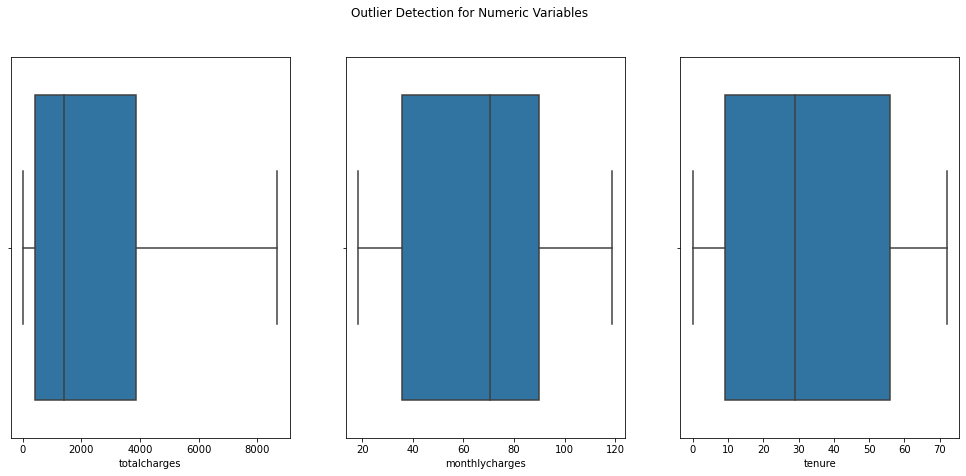

In [23]:
#Plotting box plot to visualize outliers
numerical_col=["monthlycharges","totalcharges", "tenure"]

fig,axes= plt.subplots(ncols=3,nrows=1,figsize=(17,7))
sns.boxplot(x=data['totalcharges'],ax=axes[0])
sns.boxplot(x=data['monthlycharges'],ax=axes[1])
sns.boxplot(x=data['tenure'],ax=axes[2])
title =fig.suptitle('Outlier Detection for Numeric Variables')

plt.show()

### **Observations from outlier analysis.**

* ##### Our numerical columns are within range ,as no outliers can be seen.  

* ##### However, `TotalCharges` and `MonthlyCharges` are positively and negatively skewed respectively. 
* ##### `TotalCharges` exhibits a tail that extends towards larger values (4000). Its mean, therefore is greater than the median, which is also greater than the mode.<br>
* ##### On the other hand, `MonthlyCharges` extends its tail towards the smaller values (40). This indicates a lesser mean than the median, which is also less than the mode

*  ##### The `tenure` column has a near normal distribution.

## **Dropping the rows tenure is 0 because totalcharges is a product of tenure and monthlycharges**

In [24]:
#Listing values that have 0 in `tenure` column
data[data["tenure"] == 0]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,4472-LVYGI,Female,0,True,True,0,False,False,DSL,True,...,True,True,True,False,Two year,True,Bank transfer (automatic),52.55,NaN,False
753,3115-CZMZD,Male,0,False,True,0,True,False,False,False,...,False,False,False,False,Two year,False,Mailed check,20.25,NaN,False
936,5709-LVOEQ,Female,0,True,True,0,True,False,DSL,True,...,True,False,True,True,Two year,False,Mailed check,80.85,NaN,False
1082,4367-NUYAO,Male,0,True,True,0,True,True,False,False,...,False,False,False,False,Two year,False,Mailed check,25.75,NaN,False
1340,1371-DWPAZ,Female,0,True,True,0,False,False,DSL,True,...,True,True,True,False,Two year,False,Credit card (automatic),56.05,NaN,False
218,2923-ARZLG,Male,0,True,True,0,True,False,False,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,True,Mailed check,19.70,NaN,False
1670,4075-WKNIU,Female,0,True,True,0,True,True,DSL,False,...,True,True,True,False,Two year,False,Mailed check,73.35,NaN,False
1754,2775-SEFEE,Male,0,False,True,0,True,True,DSL,True,...,False,True,False,False,Two year,True,Bank transfer (automatic),61.90,NaN,False


In [25]:
data.drop(labels=data[data["tenure"] == 0].index,axis= 0,inplace= True)

In [26]:
data[data["tenure"] == 0]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn


## **3.2 Exploratory Data Analysis (EDA).**

* #### EDA is an essential and crucial initial step in the data analysis process, where the main objective is to gain insights and understanding of the dataset before performing any formal statistical modeling or making inferences.<br> 

* #### A variety of techniques to summarize, visualize, and interpret crucial characteristics and patterns present in the data are implemented in EDA. 

* #### EDA encompasses three components: `Univariate`, `Bivariate` and `Multivariate` analysis.

### **3.2.1. Univariate Analysis** 
* ### Here, we critically examin each variable as a separate entity in terms of statistical distributions.


### **EDA of Numeric Variables**

In [27]:
numerical_col  # Get the numerical columns

['monthlycharges', 'totalcharges', 'tenure']

In [28]:
data[numerical_col].describe()

,monthlycharges,totalcharges,tenure
count,5026.000000,5026.000000,5026.000000
mean,65.102407,2299.938778,32.613808
std,30.064849,2268.113979,24.510960
min,18.400000,18.800000,1.000000
25%,35.800000,417.662500,9.000000
50%,70.575000,1400.700000,29.000000
75%,90.050000,3857.012500,56.000000
max,118.650000,8670.100000,72.000000


`MonthlyCharges`

*With the assumption that the monetary figures are quoted in usd,* 

* The `mean` monthly charge is `65usd`.
* The `least` monthly charge is `18usd`.
* `Median` monthly charge is `71usd`
* `Highest` amount charged per month is `119usd`.


`TotalCharges`

* The `mean` total charge is `2301usd`.
* The `least` total charge is `19usd`.
* `Median` total charge is `1401usd`
* `Highest` amount charged per month is `8670usd`.


`tenure`

* The `mean` tenure is `33 months`.
* The `least` recoreded `0 months`.
* `Median` is `29 months`
* `Highest` amount per month is `72 months`.

### **Frequency Distributions of Numerical Variables**

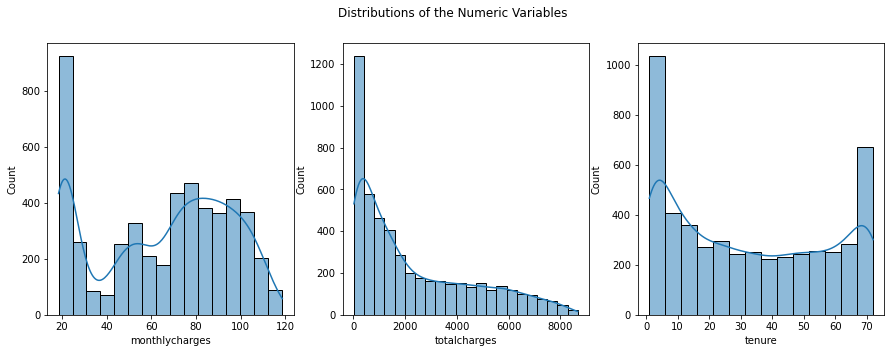

In [29]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Create a figure and three subplots
sns.histplot(data=data['monthlycharges'], kde=True, ax=axes[0])  # Plot first figure axes[0]
sns.histplot(data=data['totalcharges'], kde=True, ax=axes[1])    # Plot second figure axes[1]
sns.histplot(data=data['tenure'], kde=True, ax=axes[2])          # Plot third figure axes[2]
title = fig.suptitle('Distributions of the Numeric Variables');         # Give general title

### **Summary**
`MonthlyCharges`
* The highest(near `1000`) number of customers have very low monthly charges from about `18` usd to `25` usd.
* The middle class was charged between `50` to `100` usd.
* The top users incured above `100` usd.



`TotalCharges`

* Majority of customers have total charges below `2000` usd.
* The middle class was charged between `2000` to `6000` usd in total.
* The top users incured above `6000` usd as their total charges.


`tenure`

* Most customers have tunure of `5` months and less and above `65` months.
* On average, customers' tenure is about `35` months.

### **EDA of Categorical Variables**

In [30]:
# Create a list of categorical variables by excluding numerical columns
data = data.drop('customerid', axis=1)
categorical_variables = data.columns[~data.columns.isin(numerical_col)].tolist()
categorical_variables

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

Get the statistical summary about the categorical variables

In [31]:
# Get the statistical distribution

data[categorical_variables].describe()

,seniorcitizen
count,5026.000000
mean,0.162555
std,0.368996
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


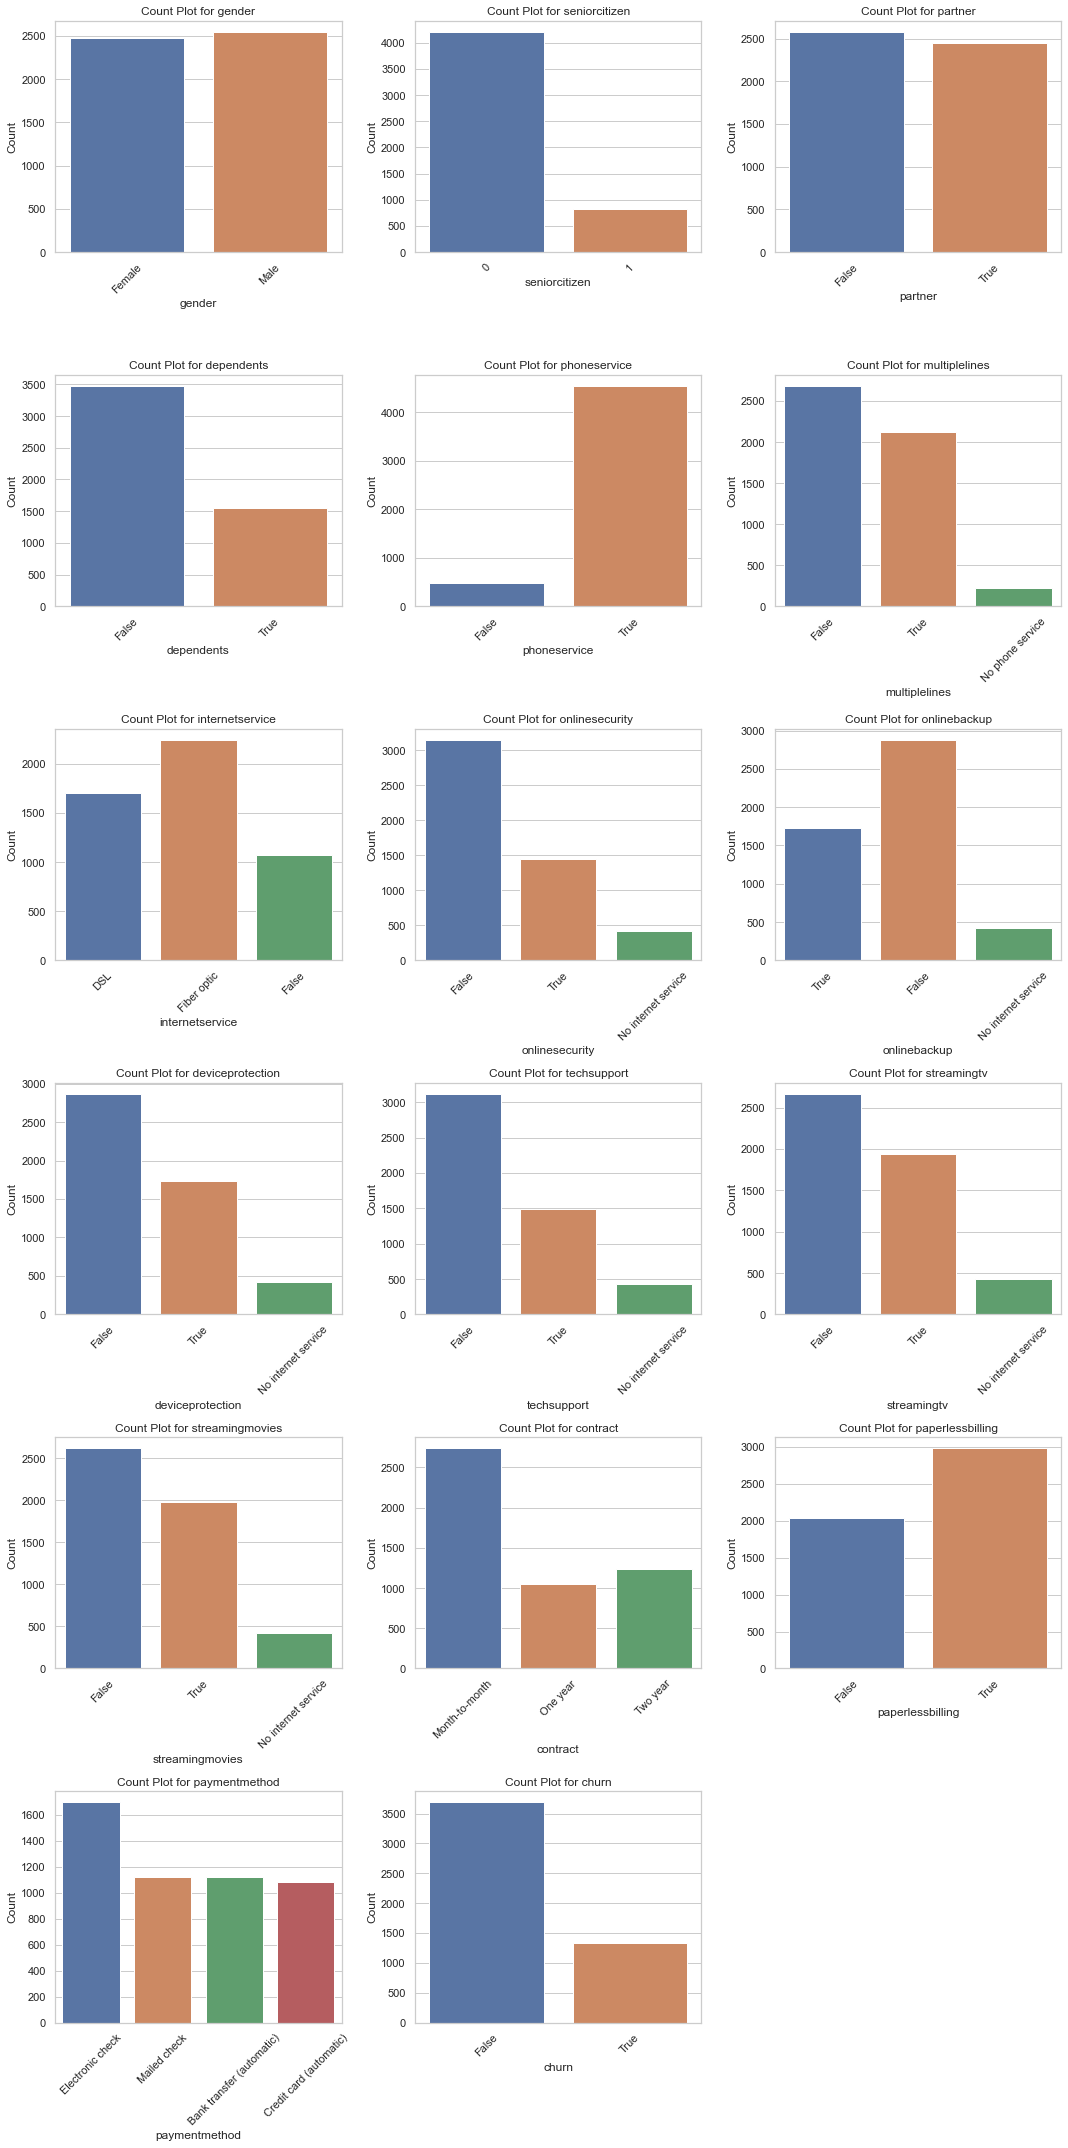

In [32]:
# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(categorical_variables) - 1) // num_cols + 1

# Plot count plots for all categorical columns
sns.set(style="whitegrid")
plt.figure(figsize=(5 * num_cols, 5 * num_rows))

for i, col in enumerate(categorical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(x=col, data=data[categorical_variables])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)

plt.tight_layout()  # To improve subplot spacing
plt.show()

### **Summary on Observations**

`Gender`<br>
For this data, gender refers to whether male or female.
There are more males than females. They account for `51% `of customers.

`Seniorcitizen`<br>
Majority of customers are not senior citizens. Out of the 5042 customers, only `819` are 60 or 65 years old and maybe are pensioners.

`Partner`<br>
Customers without partner exceed those with partner with just `128`.

`Dependents`<br>
This variable refers to whether a customer has dependents or not. From the visualization, `3481` customers have no dependents.

`Phoneservice`<br>
For whether or not a customer had subscribed to phone service, `4553`, representing 90% did subscribe.


`Multiplelines`<br>
Among the three unique options to this variable, without multiple lines outweighs the rest. `2693`customers did not have multiple lines.

`Internetservice`<br>
The internet service variable pertains to whether a customer opted for DSL, fiber optic or none. From the statistical summary, `2247`customers subscribed to fiber optic. 

`Onlinesecurity`<br>
More customers (`3158`) did not adopt the online security service.

`Onlinebackup`<BR>
Out of the 5042 customers, `2882` did not subscribe to online backup.

### **Examining the Target Variable**

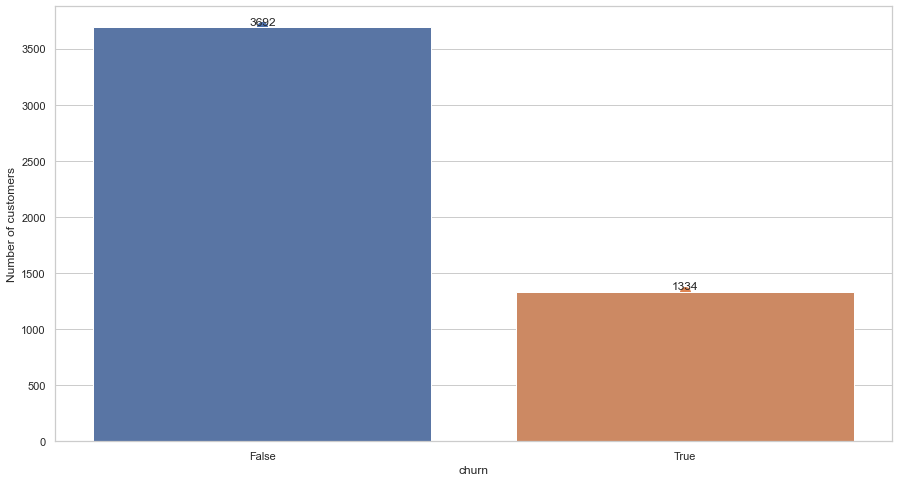

In [33]:
churn_rate=data["churn"].value_counts()
plt.figure(figsize=(15,8))
sns.countplot(x=data["churn"])
plt.ylabel("Number of customers")
for index, value in enumerate(churn_rate):
    plt.scatter(index, value, s=100)  # s=100 for marker size
    plt.annotate(str(value), xy=(index, value), xytext=(index, value+1),
                 ha='center', va='bottom', fontsize=12)

plt.show()


### **Conclusion on the Churn rate**
#### **There are 3692 customers that remained in the company and 1334 that churned meaning the retention rate is higher than the churn rate.**

## **Bivariate analysis**

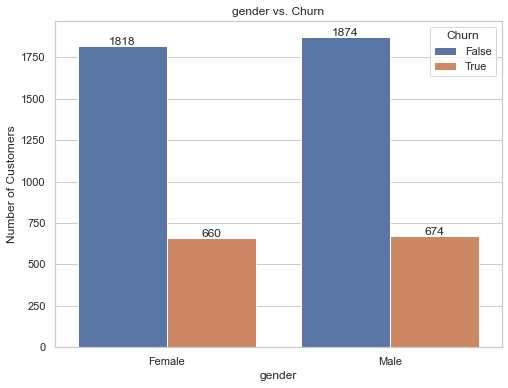

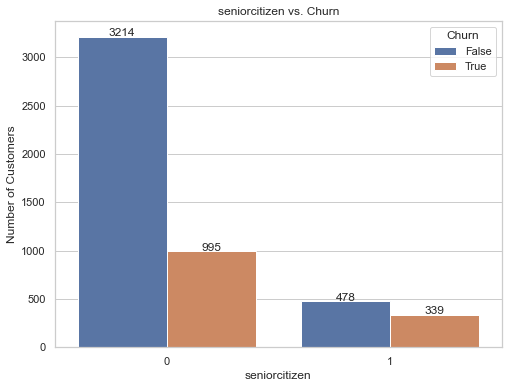

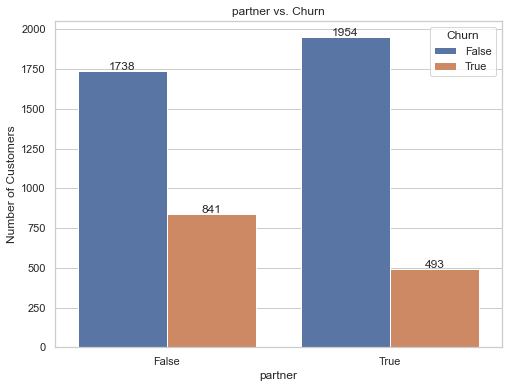

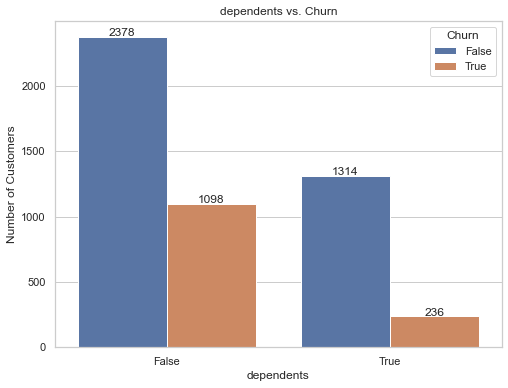

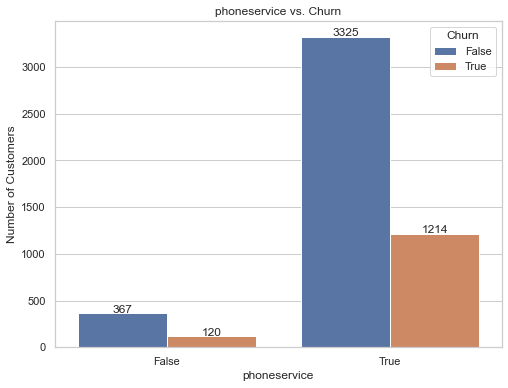

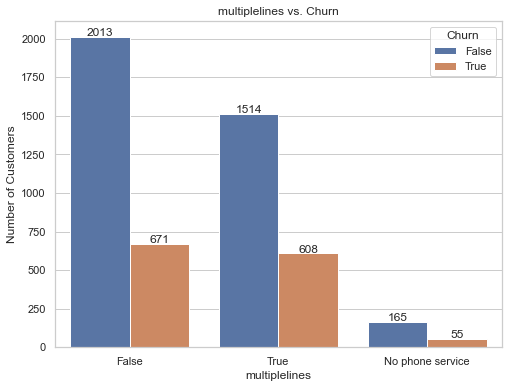

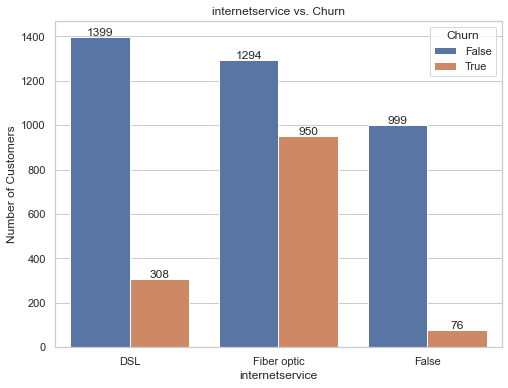

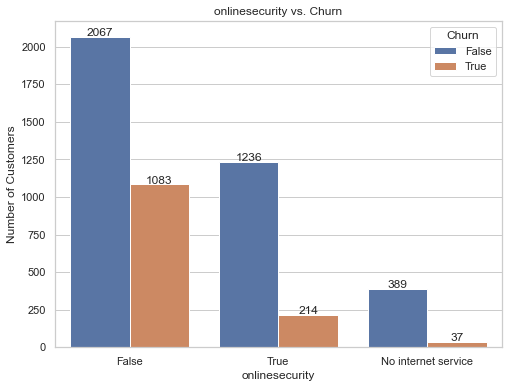

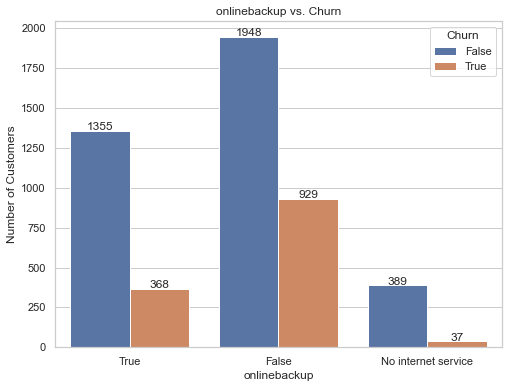

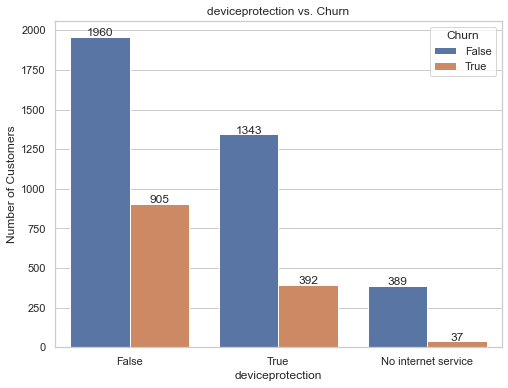

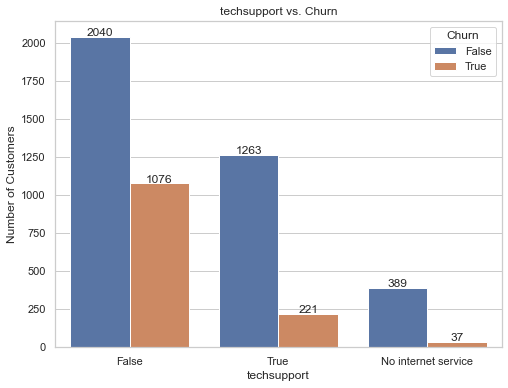

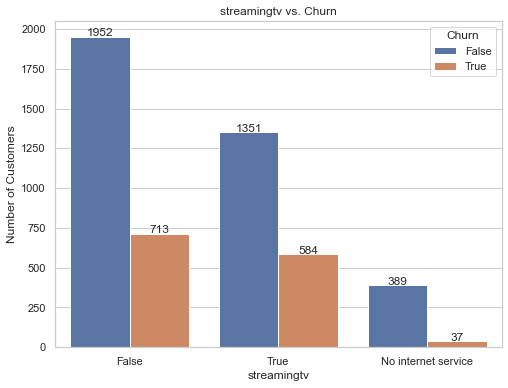

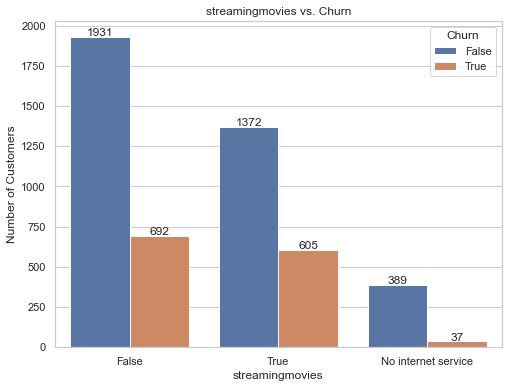

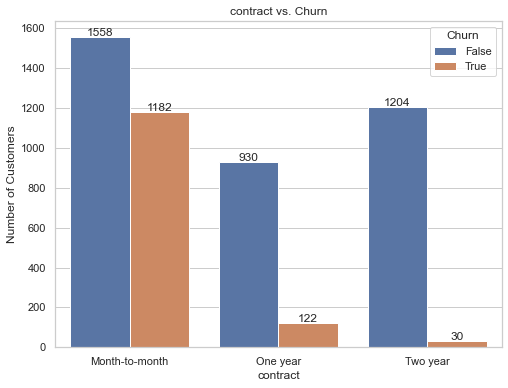

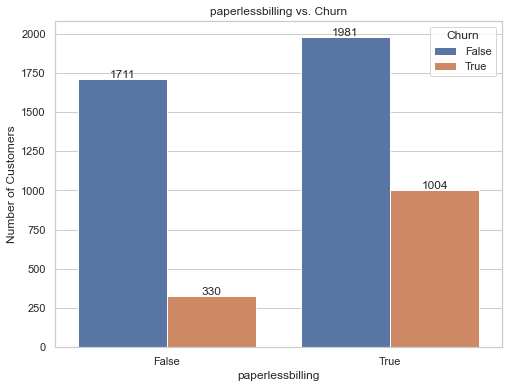

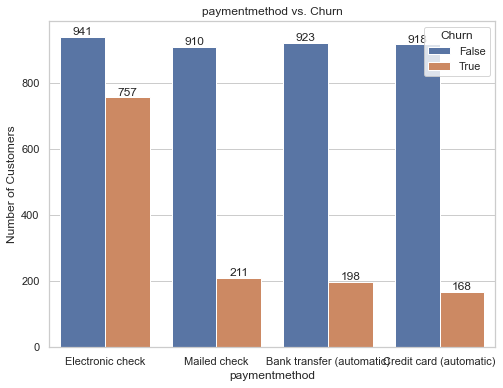

In [34]:


visualization_categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
                         'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
                         'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
                         'contract', 'paperlessbilling', 'paymentmethod']
for var in visualization_categorical_variables:
    plt.figure(figsize=(8, 6))
    ax=sns.countplot(x=var, hue='churn', data=data)
    plt.xlabel(var)
    plt.ylabel('Number of Customers')
    plt.title(f'{var} vs. Churn')
    plt.legend(title='Churn', loc='upper right')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center')

    plt.show()

 


### **Summary of Visualizations**

* #### <span style="color:white">Males are likely to leave the company more than females. The males are also likely to stay in the company more than females.</span>
* #### <span style="color:white">More senior citizens are likely to stay in a company than quit.</span>
* #### <span style="color:white">Those with partners are more likely to stay in a company as opposed to those without partners who are more likely to quit a company.</span>
* #### <span style="color:white">Those without dependents are more likely to quit the company unlike those with dependents.</span>
* #### <span style="color:white">Phone service affects greatly if a customer will churn or not.</span>
* #### <span style="color:white">Customers that use multiple lines are likely to stay in a company as opposed to others.</span>
* #### <span style="color:white">Most customers that stayed in the company are those that used DSL internet service.</span>
* #### <span style="color:white">Most customers that don't use online security are likely to stay in the company.</span>
* #### <span style="color:white">Usage of online backup doesn't make a customer stay since most customers that stayed did not utilize the online backup services.</span>
* #### <span style="color:white">Technical support can make a customer stay or leave since those that didn't use technical support were the highest contributor to a customer leaving or staying.</span>
* #### <span style="color:white">A contract period contributes to churn rate. The shorter the contract term, the higher the rate of churn.</span>
* #### <span style="color:white">Paperless billing is a major contributor to a customer not churning. Those that use paperless billing are more likely to stay.</span>
* #### <span style="color:white">Most customers that left are those that used electronic check as the method of paying.</span>


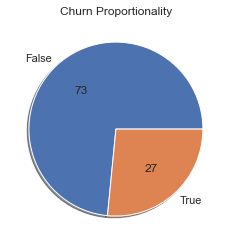

In [35]:
plt.pie(data.churn.value_counts(),
        labels= ['False', 'True'],
        autopct='%.f', shadow=True)
plt.title('Churn Proportionality')
plt.show()

### Data preprocessing.

1. Splitting data
2. One hot encode
3. Multicollinearity-
4. class imbalance
5. Dimensionality reduction-
6. Scaling

In [37]:
X=data.drop("churn",axis=1)
y= data["churn"]

In [40]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state =42)

In [42]:
print(f"The shape for X_train is {X_train.shape()}")
print(f"The shape for X_test is {X_test.shape()}")
print(f"The shape for y_train is {y_train.shape()}")
print(f"The shape for y_train is {y_train.shape()}")

TypeError: 'tuple' object is not callable